In [1]:
#importing libraries
import pandas as pd
import numpy as np
import tensorflow as tf
import random
from livelossplot import PlotLossesKeras
import matplotlib.pyplot as plt
import math
import pickle
from Utils.data_generator import LiteDataGenerator as DataGenerator
from Utils.validation_callback import AdditionalValidationSets, create_validation_sets

## Batting First

In [2]:
BF = pd.read_csv("Data/Batting_First.csv")
BF_clean = BF.drop(columns=["Toss", "Striker_Runs", "Striker_Balls", "Non_Striker_Runs", "Non_Striker_Balls",
                            "Bowler_Runs", "Bowler_Runs", "Bowler_Overs", "Bowler_Balls", "Bowler_Wickets"])
print(BF_clean.columns)


Index(['Venue', 'Batting_Team', 'Bowling_Team', 'Current_Score', 'Wickets',
       'Overs', 'Balls', 'Striker', 'Non_Striker', 'Bowler', 'Free_Hit',
       'Result'],
      dtype='object')


In [3]:
# BF = pd.read_csv("Data/Batting_First.csv")
window_size = 300
batch_size = 16
bf_train_gen = DataGenerator(BF_clean, window_size, batch_size)
bf_test_gen = DataGenerator(BF_clean, window_size, batch_size, validate=True)
validation_sets = create_validation_sets(BF_clean, ((1, 5), (6, 10), (11, 15), (16, 20)),
                                         window_size=window_size,
                                         batch_size=batch_size)

In [9]:
# with open('Data\BF_Cols.pkl', 'wb') as f:
#     pickle.dump(bf_train_gen.inp_cols, f)

In [4]:
model_inn_1 = tf.keras.Sequential([
  tf.keras.layers.Dense(512, input_shape=(None, bf_test_gen[0][0].shape[-1])),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.LSTM(256, return_sequences=True),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.LSTM(57, return_sequences=False, activation='softmax')
])
model_inn_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, None, 512)         794624    
                                                                 
 dropout (Dropout)           (None, None, 512)         0         
                                                                 
 lstm (LSTM)                 (None, None, 256)         787456    
                                                                 
 dropout_1 (Dropout)         (None, None, 256)         0         
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          82176     
                                                                 
 dropout_2 (Dropout)         (None, None, 64)          0         
                                                                 
 lstm_2 (LSTM)               (None, 57)                2

In [5]:
# model_inn_1 = tf.keras.models.load_model('Models\\Inn1_SimpleRNN_10.h5')

In [6]:
start = 0
epochs = 10
validation_callback = AdditionalValidationSets(validation_sets)
checkpoint_path_1 = (f"Models/Inn1-LSTM-ep{start}to{start+epochs}/"
                     "cp-{epoch:04d}.h5")
model_checkpoint_callback_1 = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path_1)
model_inn_1.compile(
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'],
              optimizer=tf.keras.optimizers.Adam())
history = model_inn_1.fit(bf_train_gen,
                validation_data=bf_test_gen,
                epochs=epochs,
                callbacks=[AdditionalValidationSets(validation_sets), model_checkpoint_callback_1] # , PlotLossesKeras()]
                )

Epoch 1/10
3844/3844 [==============================] - 2441s 633ms/step - loss: 1.7678 - accuracy: 0.4135 - val_loss: 1.7309 - val_accuracy: 0.4132
Epoch 2/10
 422/3844 [==>...........................] - ETA: 38:27 - loss: 1.7314 - accuracy: 0.4160

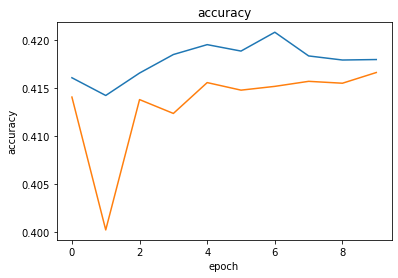

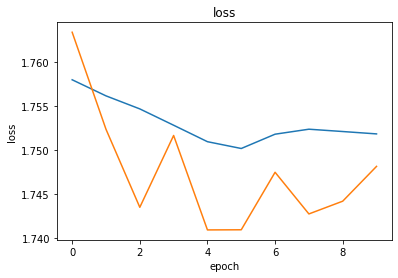

In [12]:
history_val_callback = history.history
for key in sorted([i for i in history_val_callback if i.split("_")[0]!="val"]):
    plt.plot(history_val_callback[key])
    plt.plot(history_val_callback["val_"+key])
    plt.xlabel('epoch')
    plt.ylabel(key)
    plt.title(key)
    plt.show()

In [13]:
model_inn_1.save('Models/Inn1_RNN_10to20.h5')

## Chasing

In [2]:
# del bf_train_gen, bf_test_gen
BS = pd.read_csv("Data/Chasing.csv")
BS_clean = BS.drop(columns=["Toss", "Striker_Runs", "Striker_Balls", "Non_Striker_Runs", "Non_Striker_Balls",
                            "Bowler_Runs", "Bowler_Runs", "Bowler_Overs", "Bowler_Balls", "Bowler_Wickets"])
print(BS_clean.columns)

Index(['Venue', 'Batting_Team', 'Bowling_Team', 'Current_Score', 'Wickets',
       'Overs', 'Balls', 'Striker', 'Non_Striker', 'Bowler', 'Free_Hit',
       'Target', 'Result'],
      dtype='object')


In [3]:
numerical_cols = ['Current_Score', 'Wickets', 'Overs', 'Balls', 'Target']
norm_dic = {}
BS_Norm = BS_clean.copy()
for numerical_col in numerical_cols:
    col_min = np.min(BS_Norm[numerical_col])
    col_max = np.max(BS_Norm[numerical_col])

    norm_dic[numerical_col] = (col_min, col_max)
    BS_Norm[numerical_col] = (BS_Norm[numerical_col] - col_min) / (col_max - col_min)
print(norm_dic)
BS_Norm.describe()

{'Current_Score': (0, 222), 'Wickets': (0, 9), 'Overs': (1, 20), 'Balls': (1, 9), 'Target': (68, 264)}


,Current_Score,Wickets,Overs,Balls,Free_Hit,Target,Result
count,71370.000000,71370.000000,71370.000000,71370.000000,71370.000000,71370.000000,71370.000000
mean,0.316158,0.269463,0.469236,0.326130,0.003881,0.484653,4.972622
std,0.205478,0.236335,0.292420,0.225934,0.062179,0.145354,9.846403
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.144144,0.111111,0.210526,0.125000,0.000000,0.387755,1.000000
50%,0.301802,0.222222,0.473684,0.375000,0.000000,0.489796,2.000000
75%,0.468468,0.444444,0.736842,0.500000,0.000000,0.586735,5.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,56.000000


In [5]:
window_size = 200
batch_size = 128
val_overs = ((1, 5), (6, 10), (11, 15), (16, 20))
min_overs, max_overs = norm_dic["Overs"]
val_overs_norm = (np.array(val_overs) - min_overs) / (max_overs - min_overs)
# print(val_overs_norm)
bs_train_gen = DataGenerator(BS_Norm, window_size, batch_size)
bs_test_gen = DataGenerator(BS_Norm, window_size, batch_size, validate=True)
validation_sets = create_validation_sets(BS_Norm, val_overs_norm,
                                         window_size=window_size,
                                         batch_size=batch_size)

In [6]:
# with open('Data\BS_Cols.pkl', 'wb') as f:
#     pickle.dump(bs_test_gen.inp_cols, f)

In [7]:
model_inn_2= tf.keras.Sequential([
  # tf.keras.layers.SimpleRNN(512, return_sequences=True, input_shape=(None, bs_test_gen[0][0].shape[-1])),
  tf.keras.layers.LSTM(256, input_shape=(None, bs_test_gen[0][0].shape[-1]), return_sequences=True, dropout=0.2),
  tf.keras.layers.LSTM(256, return_sequences=True, dropout=0.2),
  tf.keras.layers.LSTM(64, return_sequences=True, dropout=0.2),
  tf.keras.layers.LSTM(64, return_sequences=True, dropout=0.2),
  tf.keras.layers.LSTM(64, return_sequences=True, dropout=0.2),
  tf.keras.layers.LSTM(64, return_sequences=True, dropout=0.2),
  tf.keras.layers.LSTM(64, return_sequences=True, dropout=0.2),
  tf.keras.layers.LSTM(64, return_sequences=True, dropout=0.2),
  tf.keras.layers.LSTM(64, return_sequences=True, dropout=0.2),
  tf.keras.layers.LSTM(64, return_sequences=False, dropout=0.2),
  tf.keras.layers.Dense(57, activation="softmax"),
])
model_inn_2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 256)         1852416   
                                                                 
 lstm_1 (LSTM)               (None, None, 256)         525312    
                                                                 
 lstm_2 (LSTM)               (None, None, 64)          82176     
                                                                 
 lstm_3 (LSTM)               (None, None, 64)          33024     
                                                                 
 lstm_4 (LSTM)               (None, None, 64)          33024     
                                                                 
 lstm_5 (LSTM)               (None, None, 64)          33024     
                                                                 
 lstm_6 (LSTM)               (None, None, 64)          3

In [8]:
start = 0
epochs = 10
validation_callback = AdditionalValidationSets(validation_sets)
checkpoint_path_2 = (f"Models/Inn2Norm-LSTM-ep{start}to{start+epochs}/"
                     "cp-{epoch:04d}.h5")
model_checkpoint_callback_2 = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path_2,
    save_freq=len(bs_train_gen))
model_inn_2.compile(
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'],
              optimizer=tf.keras.optimizers.Adam())
history = model_inn_2.fit(bs_train_gen,
                validation_data=bs_test_gen,
                epochs=epochs,
                callbacks=[AdditionalValidationSets(validation_sets), model_checkpoint_callback_2] # , PlotLossesKeras()]
                )

Epoch 1/10
1860/1860 [==============================] - 2226s 1s/step - loss: 1.7644 - accuracy: 0.4017 - val_loss: 1.7492 - val_accuracy: 0.4119
Epoch 2/10
 217/1860 [==>...........................] - ETA: 20:15 - loss: 1.7196 - accuracy: 0.4124

KeyboardInterrupt: 

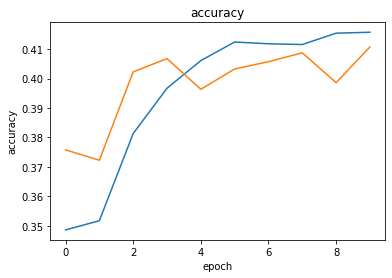

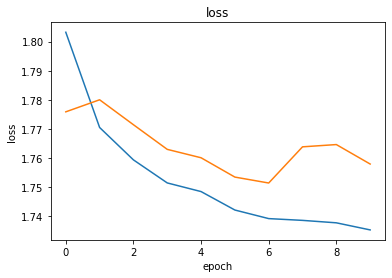

In [13]:
history_val_callback = history.history
for key in sorted([i for i in history_val_callback if i.split("_")[0]!="val"]):
    plt.plot(history_val_callback[key])
    plt.plot(history_val_callback["val_"+key])
    plt.xlabel('epoch')
    plt.ylabel(key)
    plt.title(key)
    plt.show()

In [14]:
model_inn_2.save('Models/Inn2_SimpleRNN_10_densefinal.h5')

## Visualization

In [15]:
import re
cont = 0
with open("Progress\inn2-SimpleRNN-densefinal-ep0to10.txt") as fp:
    txt_file = fp.read()
pat = re.compile(r"Epoch \d+/\d+\n"
                 r".*?loss: (\d+\.?\d*) - accuracy: (\d+\.?\d*)\n"
                 r".*?loss: (\d+\.?\d*) - accuracy: (\d+\.?\d*)\n"
                 r".*?loss: (\d+\.?\d*) - accuracy: (\d+\.?\d*)\n"
                 r".*?loss: (\d+\.?\d*) - accuracy: (\d+\.?\d*)\n"
                 r".*?loss: (\d+\.?\d*) - accuracy: (\d+\.?\d*) - val_loss: (\d+\.?\d*) - val_accuracy: (\d+\.?\d*)"
                 )
matches = re.findall(pat, txt_file)
if not cont:
    history = {"val_loss_1to5": [],
            "val_accuracy_1to5": [],
            "val_loss_6to10": [],
            "val_accuracy_6to10": [],
            "val_loss_11to15": [],
            "val_accuracy_11to15": [],
            "val_loss_16to20": [],
            "val_accuracy_16to20": [],
            "train_loss": [],
            "train_accuracy": [],
            "val_loss": [],
            "val_accuracy": [],
            }
val_overs = ((1, 5), (6, 10), (11, 15), (16, 20))
for ep in matches:
    for ind, (start, end) in enumerate(val_overs):
        history[f"val_loss_{start}to{end}"].append(float(ep[ind*2]))
        history[f"val_accuracy_{start}to{end}"].append(float(ep[ind*2 + 1]))
    history[f"train_loss"].append(float(ep[8]))
    history[f"train_accuracy"].append(float(ep[9]))
    history[f"val_loss"].append(float(ep[10]))
    history[f"val_accuracy"].append(float(ep[11]))

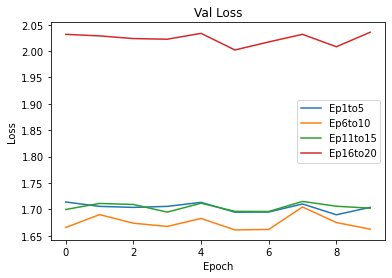

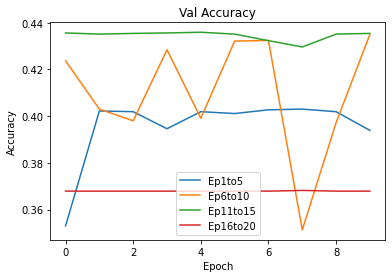

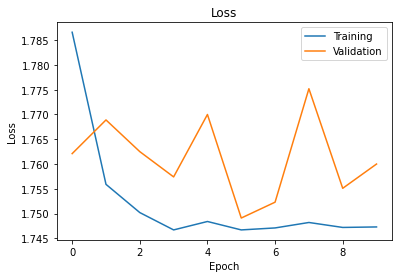

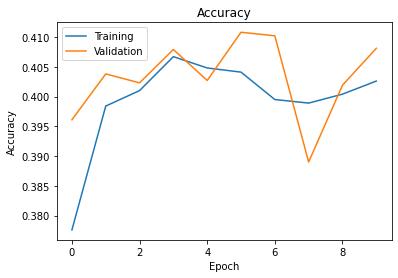

In [16]:
for (start, end) in val_overs:
    plt.plot(history[f"val_loss_{start}to{end}"], label=f"Ep{start}to{end}")
plt.legend()
plt.xlabel('Epoch')
plt.ylabel("Loss")
plt.title("Val Loss")
plt.show()

for (start, end) in val_overs:
    plt.plot(history[f"val_accuracy_{start}to{end}"], label=f"Ep{start}to{end}")
plt.legend()
plt.xlabel('Epoch')
plt.ylabel("Accuracy")
plt.title("Val Accuracy")
plt.show()

plt.plot(history["train_loss"], label="Training")
plt.plot(history["val_loss"], label="Validation")
plt.legend()
plt.xlabel('Epoch')
plt.ylabel("Loss")
plt.title("Loss")
plt.show()

plt.plot(history["train_accuracy"], label="Training")
plt.plot(history["val_accuracy"], label="Validation")
plt.legend()
plt.xlabel('Epoch')
plt.ylabel("Accuracy")
plt.title("Accuracy")
plt.show()